Import Library

In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy.stats import loguniform, uniform 


Load Data

In [2]:
try:
    train_transformed = pd.read_csv('train_transformed.csv')
    test_transformed = pd.read_csv('test_transformed.csv')
    application_test_df = pd.read_csv('application_test.csv') 
    test_ids = application_test_df['SK_ID_CURR']
    print("train_transformed, test_transformed, dan test_ids berhasil dimuat.")
except FileNotFoundError:
    print("WARNING: File transformed tidak ditemukan")

gc.collect()

train_transformed, test_transformed, dan test_ids berhasil dimuat.


0

In [3]:
print(f"Loaded train_transformed shape: {train_transformed.shape}")
print(f"Loaded test_transformed shape: {test_transformed.shape}")

Loaded train_transformed shape: (29829, 612)
Loaded test_transformed shape: (48744, 611)


##### Definisikan Fitur (X) dan Target (y)

In [4]:
print("\n--- 1. Mempersiapkan Fitur dan Target (X dan y) ---")
base_feature_cols = [col for col in train_transformed.columns if col not in ['SK_ID_CURR', 'TARGET']]

X_train = train_transformed[base_feature_cols]
y_train = train_transformed['TARGET']
X_test = test_transformed[base_feature_cols]

print(f"X_train initial shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test initial shape: {X_test.shape}")
gc.collect()



--- 1. Mempersiapkan Fitur dan Target (X dan y) ---
X_train initial shape: (29829, 610)
y_train shape: (29829,)
X_test initial shape: (48744, 610)


0

##### Validasi Akhir & Optimasi Tipe Data Fitur

In [6]:
print("\n--- 2. Validasi Akhir dan Optimasi Tipe Data Fitur ---")

# Identifikasi kolom numerik awal di X_train dan X_test
numeric_cols_train_initial = X_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_test_initial = X_test.select_dtypes(include=[np.number]).columns.tolist()

# Temukan set AKHIR dari kolom numerik umum yang dimiliki KEDUA dataset
final_feature_columns = list(set(numeric_cols_train_initial) & set(numeric_cols_test_initial))

# Debugging: Periksa jumlah kolom yang umum
print(f"Jumlah kolom numerik di X_train awal: {len(numeric_cols_train_initial)}")
print(f"Jumlah kolom numerik di X_test awal: {len(numeric_cols_test_initial)}")
print(f"Jumlah kolom fitur umum (final_feature_columns): {len(final_feature_columns)}")

# Filter X_train dan X_test untuk hanya menyertakan kolom-kolom ini
X_train = X_train[final_feature_columns]
X_test = X_test[final_feature_columns]

# Pengecekan Kritis: Pastikan jumlah kolom sama setelah filter
if X_train.shape[1] != X_test.shape[1]:
    raise ValueError("ERROR KRITIS: Jumlah kolom X_train dan X_test tidak sama setelah filter!")
if X_train.shape[1] != len(final_feature_columns):
    raise ValueError("ERROR KRITIS: Jumlah kolom X_train tidak cocok dengan daftar final_feature_columns!")

print(f"X_train shape setelah filter final_feature_columns: {X_train.shape}")
print(f"X_test shape setelah filter final_feature_columns: {X_test.shape}")


# Optimalkan Tipe Data Akhir
for col in X_train.columns: # Iterasi melalui kolom X_train, yang sekarang adalah final_feature_columns
    X_train[col] = X_train[col].astype(np.float32)
    X_test[col] = X_test[col].astype(np.float32)

print("Tipe data dioptimalkan")
gc.collect()


--- 2. Validasi Akhir dan Optimasi Tipe Data Fitur ---
Jumlah kolom numerik di X_train awal: 594
Jumlah kolom numerik di X_test awal: 594
Jumlah kolom fitur umum (final_feature_columns): 594
X_train shape setelah filter final_feature_columns: (29829, 594)
X_test shape setelah filter final_feature_columns: (48744, 594)
Tipe data dioptimalkan


0

##### 3. Mengambil Sample Data untuk Tuning

In [7]:
print(f"\n--- 3. Mengambil Sampel Data untuk Hyperparameter Tuning ---")
sample_fraction_for_tuning = 0.5 

X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, train_size=sample_fraction_for_tuning, stratify=y_train, random_state=42
)
print(f"Shape X_train_sample untuk tuning: {X_train_sample.shape}")
gc.collect()


--- 3. Mengambil Sampel Data untuk Hyperparameter Tuning ---
Shape X_train_sample untuk tuning: (14914, 594)


0

##### 4. Inisialisasi Model Logistic Regression & Setup Tuning

In [8]:
print("\n--- 4. Inisialisasi Model Logistic Regression & Setup Tuning ---")

log_reg_base = LogisticRegression(
    solver='saga',
    penalty='elasticnet', 
    random_state=42,
    n_jobs=-1, 
    max_iter=1000, 
    class_weight='balanced' 
)

param_distributions_log_reg = {
    'C': loguniform(0.001, 100),
    'l1_ratio': uniform(0, 1) 
}

# Strategi Cross-Validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_log_reg = RandomizedSearchCV(estimator=log_reg_base, param_distributions=param_distributions_log_reg,
                                       n_iter=20, 
                                       scoring='roc_auc',
                                       cv=cv_strategy,
                                       verbose=2, 
                                       random_state=42,
                                       n_jobs=1) 


print("Setup tuning Logistic Regression selesai.")
gc.collect()


--- 4. Inisialisasi Model Logistic Regression & Setup Tuning ---
Setup tuning Logistic Regression selesai.


0

##### 5. Melakukan Hyperparameter Tuning (Fit RandomizedSearchCV)

In [9]:
print("\n--- 5. Memulai Hyperparameter Tuning Logistic Regression (Random Search) ---")

X_train_fit_for_tuning, X_val_fit_for_tuning, y_train_fit_for_tuning, y_val_fit_for_tuning = train_test_split(
    X_train_sample, y_train_sample, test_size=0.5, random_state=42, stratify=y_train_sample
)
print(f"Shape X_train_fit_for_tuning: {X_train_fit_for_tuning.shape}")
print(f"Shape X_val_fit_for_tuning: {X_val_fit_for_tuning.shape}")


--- 5. Memulai Hyperparameter Tuning Logistic Regression (Random Search) ---
Shape X_train_fit_for_tuning: (7457, 594)
Shape X_val_fit_for_tuning: (7457, 594)


In [10]:
random_search_log_reg.fit(X_train_fit_for_tuning, y_train_fit_for_tuning)
print("Hyperparameter Tuning Logistic Regression selesai.")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=0.0745934328572655, l1_ratio=0.9507143064099162; total time= 1.7min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=0.0745934328572655, l1_ratio=0.9507143064099162; total time= 1.6min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=0.0745934328572655, l1_ratio=0.9507143064099162; total time= 1.6min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=0.0745934328572655, l1_ratio=0.9507143064099162; total time= 1.6min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=0.0745934328572655, l1_ratio=0.9507143064099162; total time= 1.6min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=4.5705630998014515, l1_ratio=0.5986584841970366; total time= 1.7min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=4.5705630998014515, l1_ratio=0.5986584841970366; total time= 1.5min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=4.5705630998014515, l1_ratio=0.5986584841970366; total time= 1.5min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=4.5705630998014515, l1_ratio=0.5986584841970366; total time= 1.5min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=4.5705630998014515, l1_ratio=0.5986584841970366; total time= 1.5min
[CV] END C=0.006026889128682512, l1_ratio=0.15599452033620265; total time=  12.7s
[CV] END C=0.006026889128682512, l1_ratio=0.15599452033620265; total time=  13.0s
[CV] END C=0.006026889128682512, l1_ratio=0.15599452033620265; total time=  13.2s
[CV] END C=0.006026889128682512, l1_ratio=0.15599452033620265; total time=  13.7s
[CV] END C=0.006026889128682512, l1_ratio=0.15599452033620265; total time=  13.4s
[CV] END C=0.0019517224641449498, l1_ratio=0.8661761457749352; total time=   3.7s
[CV] END C=0.0019517224641449498, l1_ratio=0.8661761457749352; total time=   3.5s
[CV] END C=0.0019517224641449498, l1_ratio=0.8661761457749352; total time=   3.6s
[CV] END C=0.0019517224641449498, l1_ratio=0.8661761457749352; total time=   2.8s
[CV] END C=0.0019517224641449498, l1_ratio=0.8661761457749352; total time=   3.2s


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=1.0129197956845732, l1_ratio=0.7080725777960455; total time= 1.5min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=1.0129197956845732, l1_ratio=0.7080725777960455; total time= 1.5min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=1.0129197956845732, l1_ratio=0.7080725777960455; total time= 1.5min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=1.0129197956845732, l1_ratio=0.7080725777960455; total time= 1.4min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=1.0129197956845732, l1_ratio=0.7080725777960455; total time= 1.5min
[CV] END C=0.001267425589893723, l1_ratio=0.9699098521619943; total time=   3.0s
[CV] END C=0.001267425589893723, l1_ratio=0.9699098521619943; total time=   3.6s
[CV] END C=0.001267425589893723, l1_ratio=0.9699098521619943; total time=   3.2s
[CV] END C=0.001267425589893723, l1_ratio=0.9699098521619943; total time=   2.8s
[CV] END C=0.001267425589893723, l1_ratio=0.9699098521619943; total time=   3.0s


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=14.528246637516036, l1_ratio=0.21233911067827616; total time= 1.5min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=14.528246637516036, l1_ratio=0.21233911067827616; total time= 1.5min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=14.528246637516036, l1_ratio=0.21233911067827616; total time= 1.6min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=14.528246637516036, l1_ratio=0.21233911067827616; total time= 1.6min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=14.528246637516036, l1_ratio=0.21233911067827616; total time= 1.5min
[CV] END C=0.008111941985431923, l1_ratio=0.18340450985343382; total time=  15.7s
[CV] END C=0.008111941985431923, l1_ratio=0.18340450985343382; total time=  16.3s
[CV] END C=0.008111941985431923, l1_ratio=0.18340450985343382; total time=  14.9s
[CV] END C=0.008111941985431923, l1_ratio=0.18340450985343382; total time=  16.2s
[CV] END C=0.008111941985431923, l1_ratio=0.18340450985343382; total time=  14.8s
[CV] END C=0.033205591037519584, l1_ratio=0.5247564316322378; total time=  48.7s
[CV] END C=0.033205591037519584, l1_ratio=0.5247564316322378; total time=  55.9s
[CV] END C=0.033205591037519584, l1_ratio=0.5247564316322378; total time=  35.8s
[CV] END C=0.033205591037519584, l1_ratio=0.5247564316322378; total time=  53.2s
[CV] END C=0.033205591037519584, l1_ratio=0.5247564316322378; total time=  54.7s


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=0.14445251022763064, l1_ratio=0.2912291401980419; total time= 1.5min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=0.14445251022763064, l1_ratio=0.2912291401980419; total time= 1.4min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=0.14445251022763064, l1_ratio=0.2912291401980419; total time= 1.4min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=0.14445251022763064, l1_ratio=0.2912291401980419; total time= 1.4min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=0.14445251022763064, l1_ratio=0.2912291401980419; total time=42.1min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=1.1462107403425035, l1_ratio=0.13949386065204183; total time= 1.5min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=1.1462107403425035, l1_ratio=0.13949386065204183; total time= 1.6min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=1.1462107403425035, l1_ratio=0.13949386065204183; total time= 1.7min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=1.1462107403425035, l1_ratio=0.13949386065204183; total time= 1.7min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=1.1462107403425035, l1_ratio=0.13949386065204183; total time= 1.8min
[CV] END C=0.028888383623653185, l1_ratio=0.3663618432936917; total time= 1.0min
[CV] END C=0.028888383623653185, l1_ratio=0.3663618432936917; total time= 1.2min
[CV] END C=0.028888383623653185, l1_ratio=0.3663618432936917; total time=  42.4s
[CV] END C=0.028888383623653185, l1_ratio=0.3663618432936917; total time=  51.4s
[CV] END C=0.028888383623653185, l1_ratio=0.3663618432936917; total time=  58.6s


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=0.19069966103000435, l1_ratio=0.7851759613930136; total time= 1.5min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=0.19069966103000435, l1_ratio=0.7851759613930136; total time= 1.5min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=0.19069966103000435, l1_ratio=0.7851759613930136; total time= 1.3min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=0.19069966103000435, l1_ratio=0.7851759613930136; total time= 1.6min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=0.19069966103000435, l1_ratio=0.7851759613930136; total time= 1.5min
[CV] END C=0.009962513222055111, l1_ratio=0.5142344384136116; total time=  20.4s
[CV] END C=0.009962513222055111, l1_ratio=0.5142344384136116; total time=  19.2s
[CV] END C=0.009962513222055111, l1_ratio=0.5142344384136116; total time=  18.9s
[CV] END C=0.009962513222055111, l1_ratio=0.5142344384136116; total time=  26.4s
[CV] END C=0.009962513222055111, l1_ratio=0.5142344384136116; total time=  16.3s


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.9163741808778786, l1_ratio=0.046450412719997725; total time= 1.7min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.9163741808778786, l1_ratio=0.046450412719997725; total time= 1.7min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.9163741808778786, l1_ratio=0.046450412719997725; total time= 1.8min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.9163741808778786, l1_ratio=0.046450412719997725; total time= 1.8min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.9163741808778786, l1_ratio=0.046450412719997725; total time= 1.8min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=1.0907475835157696, l1_ratio=0.17052412368729153; total time= 1.7min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=1.0907475835157696, l1_ratio=0.17052412368729153; total time= 1.6min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=1.0907475835157696, l1_ratio=0.17052412368729153; total time= 1.9min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=1.0907475835157696, l1_ratio=0.17052412368729153; total time= 1.7min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .C=1.0907475835157696, l1_ratio=0.17052412368729153; total time= 1.7min
[CV] END C=0.0021147447960615704, l1_ratio=0.9488855372533332; total time=   5.1s
[CV] END C=0.0021147447960615704, l1_ratio=0.9488855372533332; total time=   5.2s
[CV] END C=0.0021147447960615704, l1_ratio=0.9488855372533332; total time=   4.2s
[CV] END C=0.0021147447960615704, l1_ratio=0.9488855372533332; total time=   3.4s
[CV] END C=0.0021147447960615704, l1_ratio=0.9488855372533332; total time=   3.7s


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...C=67.32248920775338, l1_ratio=0.8083973481164611; total time= 1.8min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...C=67.32248920775338, l1_ratio=0.8083973481164611; total time= 1.7min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...C=67.32248920775338, l1_ratio=0.8083973481164611; total time= 1.8min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...C=67.32248920775338, l1_ratio=0.8083973481164611; total time= 1.8min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...C=67.32248920775338, l1_ratio=0.8083973481164611; total time= 1.9min
[CV] END C=0.03334792728637585, l1_ratio=0.09767211400638387; total time= 1.1min
[CV] END C=0.03334792728637585, l1_ratio=0.09767211400638387; total time= 1.2min
[CV] END C=0.03334792728637585, l1_ratio=0.09767211400638387; total time=  56.3s
[CV] END C=0.03334792728637585, l1_ratio=0.09767211400638387; total time=  53.6s
[CV] END C=0.03334792728637585, l1_ratio=0.09767211400638387; total time= 1.1min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=2.6373339933815254, l1_ratio=0.4401524937396013; total time= 1.5min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=2.6373339933815254, l1_ratio=0.4401524937396013; total time= 1.4min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=2.6373339933815254, l1_ratio=0.4401524937396013; total time= 1.4min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=2.6373339933815254, l1_ratio=0.4401524937396013; total time= 1.4min


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=2.6373339933815254, l1_ratio=0.4401524937396013; total time= 1.5min
Hyperparameter Tuning Logistic Regression selesai.


##### 6. Hasil Tuning Terbaik

In [12]:
print("\n--- 6. Hasil Tuning Logistic Regression ---")
best_params = random_search_log_reg.best_params_
best_cv_auc = random_search_log_reg.best_score_
print("Best parameters found: ", best_params)
print("Best ROC AUC score (on sample data, cross-validated): ", best_cv_auc)



--- 6. Hasil Tuning Logistic Regression ---
Best parameters found:  {'C': np.float64(0.009962513222055111), 'l1_ratio': np.float64(0.5142344384136116)}
Best ROC AUC score (on sample data, cross-validated):  0.7436315240381866


##### 7. Visualisasi ROC-AUC Dari Model Terbaik Pada Validasi Sample


--- 7. Visualisasi ROC AUC ---
ROC AUC Score on specific validation set for plot: 0.7295


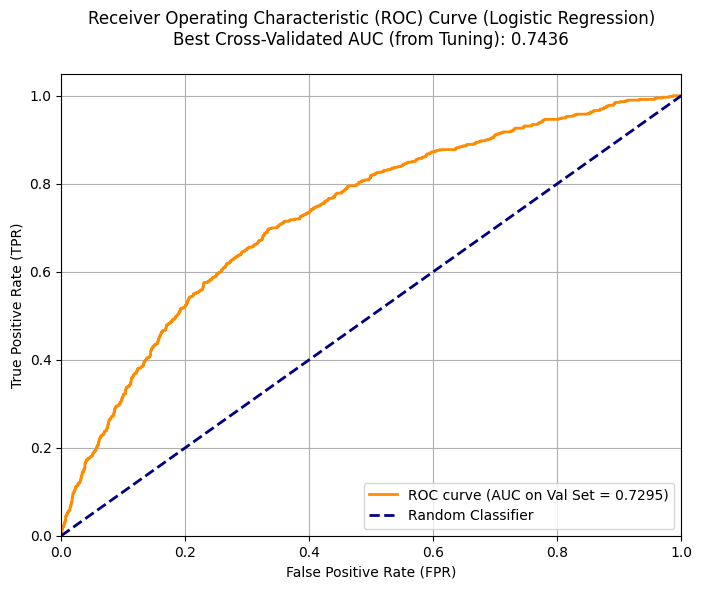

In [13]:
print("\n--- 7. Visualisasi ROC AUC ---")

y_val_pred_proba = random_search_log_reg.best_estimator_.predict_proba(X_val_fit_for_tuning)[:, 1]

# Hitung False Positive Rate (FPR), True Positive Rate (TPR), dan Thresholds
fpr, tpr, thresholds = roc_curve(y_val_fit_for_tuning, y_val_pred_proba)

# Hitung Area Under the Curve (AUC) untuk kurva yang diplot
roc_auc_for_plot = auc(fpr, tpr)

print(f"ROC AUC Score on specific validation set for plot: {roc_auc_for_plot:.4f}")

# Plot Kurva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC on Val Set = {roc_auc_for_plot:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'Receiver Operating Characteristic (ROC) Curve (Logistic Regression)\n'
          f'Best Cross-Validated AUC (from Tuning): {best_cv_auc:.4f}\n')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

##### 8. Melatih Model Logistic Regression Final Pada Seluruh Data Train

In [14]:
print("\n--- 8. Melatih Model Logistic Regression Final pada SELURUH Data Training ---")

# Inisialisasi model Logistic Regression baru dengan parameter terbaik
final_log_reg_model = LogisticRegression(
    solver='saga',
    penalty='elasticnet',
    random_state=42,
    n_jobs=-1,
    max_iter=20,
    class_weight='balanced', 
    **best_params 
)

# Latih model final pada SELURUH data training (X_train dan y_train)
print(f"Memulai pelatihan model final pada X_train.shape: {X_train.shape}")
final_log_reg_model.fit(X_train, y_train)
print("Pelatihan model final selesai.")
gc.collect()


--- 8. Melatih Model Logistic Regression Final pada SELURUH Data Training ---
Memulai pelatihan model final pada X_train.shape: (29829, 594)


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pelatihan model final selesai.


3156

##### 9. Membuat Prediksi Data Uji (Test Data) dengan Model Final

In [15]:
print("\n--- 9. Membuat Prediksi pada Data Uji dengan Model Final ---")
test_preds = final_log_reg_model.predict_proba(X_test)[:, 1]
print("Prediksi pada data uji selesai.")


--- 9. Membuat Prediksi pada Data Uji dengan Model Final ---
Prediksi pada data uji selesai.


##### 10. Membuat File Submission

In [17]:
print("\n--- 10. Membuat File Submission ---")
submission_df = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_preds})
submission_filename = 'submission_logistic.csv'
submission_df.to_csv(submission_filename, index=False)
print(f"\nFile submission '{submission_filename}' berhasil dibuat.")


--- 10. Membuat File Submission ---

File submission 'submission_logistic.csv' berhasil dibuat.


Menggunakan threshold = 0.5 untuk mengklasifikasikan probabilitas.

Jumlah prediksi untuk setiap kelas:
PREDICTED_CLASS
0    32630
1    16114
Name: count, dtype: int64

Persentase prediksi untuk setiap kelas:
PREDICTED_CLASS
0    66.94
1    33.06
Name: proportion, dtype: float64


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13228\4162496940.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


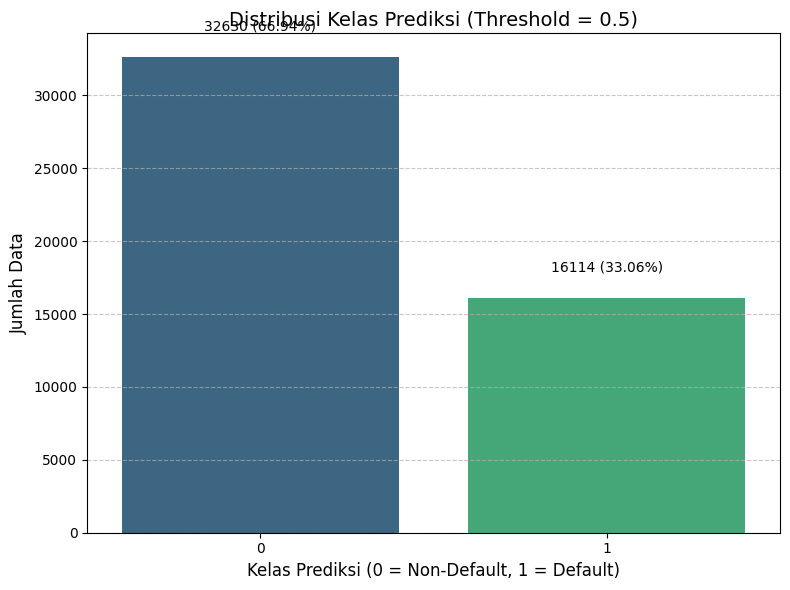

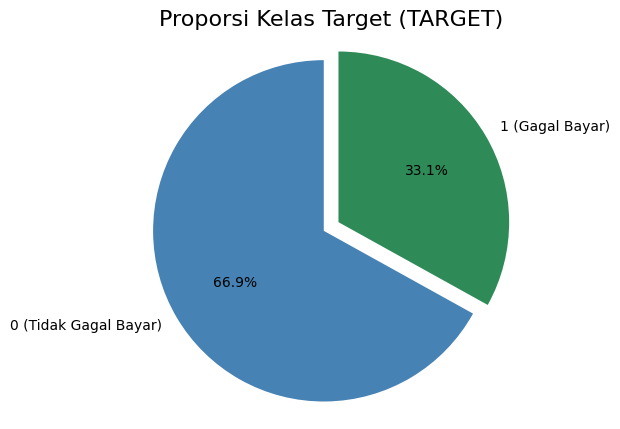

In [18]:
import seaborn as sns 

threshold = 0.5
print(f"Menggunakan threshold = {threshold} untuk mengklasifikasikan probabilitas.")

# Buat Kolom 'PREDICTED_CLASS' 
submission_df['PREDICTED_CLASS'] = (submission_df['TARGET'] > threshold).astype(int)

# Hitung Jumlah Kemunculan Setiap Kelas
class_counts = submission_df['PREDICTED_CLASS'].value_counts().sort_index()
class_percentages = submission_df['PREDICTED_CLASS'].value_counts(normalize=True).sort_index() * 100

print("\nJumlah prediksi untuk setiap kelas:")
print(class_counts)
print("\nPersentase prediksi untuk setiap kelas:")
print(class_percentages.round(2)) 

# Buat Visualisasi Bar Plot 
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

# Tambahkan label nilai 
for index, value in enumerate(class_counts.values):
    plt.text(index, value + 0.05 * max(class_counts.values),
             f'{value} ({class_percentages.iloc[index]:.2f}%)',
             ha='center', va='bottom', fontsize=10)

plt.title(f'Distribusi Kelas Prediksi (Threshold = {threshold})', fontsize=14)
plt.xlabel('Kelas Prediksi (0 = Non-Default, 1 = Default)', fontsize=12)
plt.ylabel('Jumlah Data', fontsize=12)
plt.xticks([0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualisasi Pie Chart
plt.figure(figsize=(5,5))
plt.pie(class_counts, labels=['0 (Tidak Gagal Bayar)', '1 (Gagal Bayar)'],
        autopct='%1.1f%%', startangle=90, colors=['steelblue','seagreen'], explode=(0, 0.1))
plt.title('Proporsi Kelas Target (TARGET)', fontsize=16)
plt.axis('equal') 
plt.show()


Menghitung metrik dengan ambang batas (threshold) = 0.5
Accuracy:  0.7027
Precision: 0.1610
Recall:    0.6460
F1-Score:  0.2578
ROC AUC:   0.7295


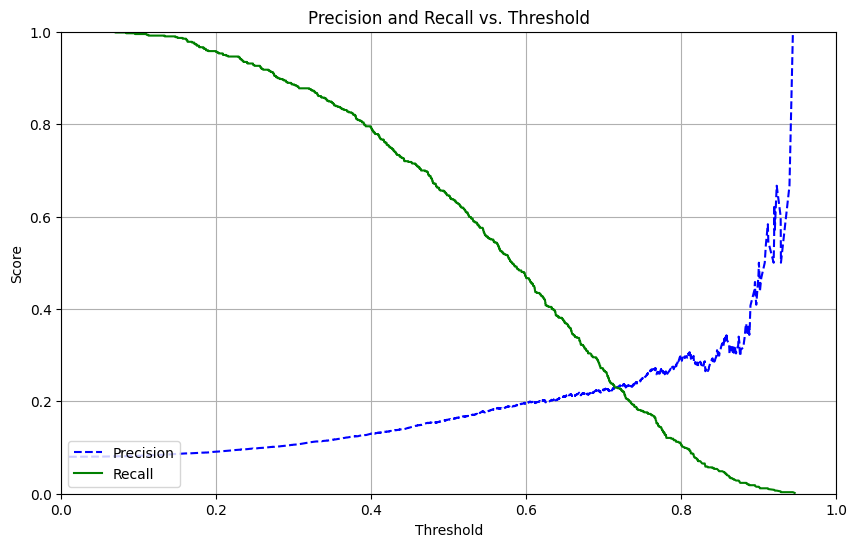

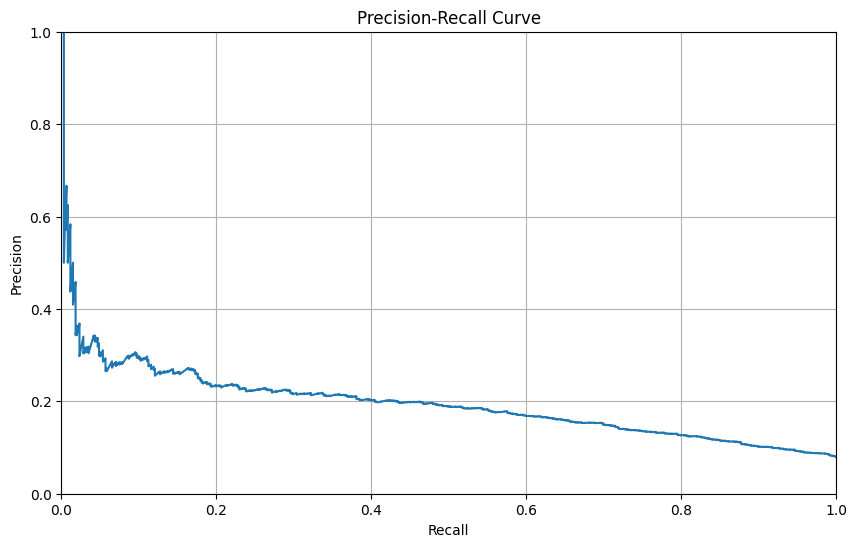

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

threshold = 0.5
print(f"\nMenghitung metrik dengan ambang batas (threshold) = {threshold}")

# Jika probabilitas > threshold, prediksinya 1; jika tidak, 0.
y_pred_binary = (y_val_pred_proba > threshold).astype(int)

accuracy = accuracy_score(y_val_fit_for_tuning, y_pred_binary)
precision = precision_score(y_val_fit_for_tuning, y_pred_binary)
recall = recall_score(y_val_fit_for_tuning, y_pred_binary)
f1 = f1_score(y_val_fit_for_tuning, y_pred_binary)

roc_auc = roc_auc_score(y_val_fit_for_tuning, y_val_pred_proba)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

## Visualisasi Trade-off Precision-Recall

from sklearn.metrics import precision_recall_curve

# Hitung Precision, Recall, dan Thresholds untuk berbagai titik pada kurva
precisions, recalls, thresholds = precision_recall_curve(y_val_fit_for_tuning, y_val_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend(loc='lower left')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

# Plot Kurva Precision-Recall
# Ini menunjukkan trade-off langsung antara Precision dan Recall
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()